<a href="https://colab.research.google.com/github/pouyarahmti/Pytorch-Deep-Learning-Bootcamp/blob/main/06_PyTorch_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 06 PyTorch Transfer Learning

Transfer Learning involves taking parameters from a pre-trained model and fine-tuning it for a new task.

* Pre-trained model = Foundation model

In [26]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)


2.3.0+cu121
0.18.0+cu121


In [27]:
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

In [28]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## 1. Get the data

In [29]:
!wget https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip

--2024-05-26 17:44:44--  https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip [following]
--2024-05-26 17:44:44--  https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/data/pizza_steak_sushi.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15737296 (15M) [application/zip]
Saving to: ‘pizza_steak_sushi.zip’

pizza_steak_sushi.z 100%[===================>]  15.01M  --.-KB/s    in 0.04s   

2024-05-26 17:44:45 (391 MB/s) - ‘pizza_s

In [30]:
import os
import zipfile

from pathlib import Path

data_path = Path("data/")
images_path = data_path / "pizza_steak_sushi"

if images_path.is_dir():
    print(f"{images_path} directory exists")
else:
    print(f"Did not find {images_path} directory, creating one...")
    images_path.mkdir(parents=True, exist_ok=True)


with zipfile.ZipFile("pizza_steak_sushi.zip", "r") as zip_ref:
    print("Extracting images...")
    zip_ref.extractall(images_path)
    print("Done!")


os.remove("pizza_steak_sushi.zip")


data/pizza_steak_sushi directory exists
Extracting images...
Done!


In [31]:
# Setup Directory Paths
train_dir = images_path / "train"
test_dir = images_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

## 2. Create Dataset and DataLoader

**Import** `torchvision.datasets` and `torch.utils.data.DataLoader`:
  when using a pre-trained model we need to make sure the data (even our custom data) is in the correct format of the model.

  there are two ways to do this:

  1. use Manual tranforms
  2. use Automatically created transforms from `torchvision.models.transforms`

### 2.1 Creating a tranform for `torchvision.models`

In [32]:
from going_modular.going_modular import data_setup

In [33]:
# Get a set of pretrained weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # "DEFAULT" = means best available weights
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [34]:
# Get the tranforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [35]:
# Create DataLoaders with DataSetup
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=auto_transforms,
    batch_size=32
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c3a2c5ba5f0>,
 ['pizza', 'steak', 'sushi'])

## 3. Getting a pretrained model

there are multiple places to get a pretrained model:
1. PyTorch domain libraries
2. Libraries like 'timm'
3. The Hugging Face model hub
4. Paperswithcode
5. Other places

### 3.1 Which model to use?

**Experiment, Experiment, Experiment!**

Three things to consider:
1. Speed - is it fast enough?
2. Size - how big is it?
3. Accuracy - is it accurate enough?

Where does the model live?
is it on device? is it on cloud?

### 3.2 Setting up the model

In [36]:
# Setup the model

weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

model

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [37]:
### 3.3 Getting summary of our model

from torchinfo import summary
summary(model,
        (1,3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 1000]            --                   True
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   True
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   True
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    864                  True
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    64                   True
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 16, 112,

### 3.4 Freezing the base model and changing the head (output layer) to match the number of classes in the dataset



In [38]:
# Freeze all of the base layers in the model


# Freeze all of the base layers in the model
for param in model.features.parameters():
    param.requires_grad = False



In [39]:
# update the classifier head
num_classes = len(class_names)

torch.manual_seed(42)

model.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280,
              out_features=num_classes,
              bias=True))

model.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [40]:
summary(model,
        (1,3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1280, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

## 4. Training the model

In [41]:
# Define the loss function
loss_fn = nn.CrossEntropyLoss()

# Define an optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [42]:
from going_modular.going_modular import engine

# Set manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set the number of epochs
EPOCHS = 10

# start the timer
from timeit import default_timer as timer
start_time = timer()

results = engine.train(model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=EPOCHS,
                        device=device)

end_time = timer()
total_train_time_model_0 = end_time-start_time
print(f"Total training time: {total_train_time_model_0:.3f} seconds")

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0924 | train_acc: 0.3984 | test_loss: 0.9133 | test_acc: 0.5398
Epoch: 2 | train_loss: 0.8717 | train_acc: 0.7773 | test_loss: 0.7912 | test_acc: 0.8153
Epoch: 3 | train_loss: 0.7648 | train_acc: 0.7930 | test_loss: 0.7463 | test_acc: 0.8561
Epoch: 4 | train_loss: 0.7109 | train_acc: 0.7539 | test_loss: 0.6373 | test_acc: 0.8655
Epoch: 5 | train_loss: 0.6255 | train_acc: 0.7852 | test_loss: 0.6261 | test_acc: 0.8561
Epoch: 6 | train_loss: 0.5785 | train_acc: 0.8945 | test_loss: 0.5743 | test_acc: 0.8759
Epoch: 7 | train_loss: 0.5263 | train_acc: 0.9102 | test_loss: 0.5470 | test_acc: 0.8759
Epoch: 8 | train_loss: 0.5226 | train_acc: 0.8008 | test_loss: 0.5291 | test_acc: 0.8665
Epoch: 9 | train_loss: 0.5671 | train_acc: 0.8125 | test_loss: 0.5076 | test_acc: 0.8456
Epoch: 10 | train_loss: 0.4847 | train_acc: 0.8203 | test_loss: 0.4400 | test_acc: 0.9062
Total training time: 23.788 seconds


In [45]:
results

{'train_loss': [1.0924270078539848,
  0.8716965168714523,
  0.7647949680685997,
  0.7108824849128723,
  0.6254763826727867,
  0.5784516036510468,
  0.5262740403413773,
  0.5226370766758919,
  0.5670521818101406,
  0.4847053103148937],
 'train_acc': [0.3984375,
  0.77734375,
  0.79296875,
  0.75390625,
  0.78515625,
  0.89453125,
  0.91015625,
  0.80078125,
  0.8125,
  0.8203125],
 'test_loss': [0.9132681290308634,
  0.7911976178487142,
  0.7463406324386597,
  0.6373109420140585,
  0.6261006395022074,
  0.5743226806322733,
  0.5469824274381002,
  0.5290800531705221,
  0.5076459646224976,
  0.43997156620025635],
 'test_acc': [0.5397727272727273,
  0.8153409090909092,
  0.8560606060606061,
  0.8655303030303031,
  0.8560606060606061,
  0.8759469696969697,
  0.8759469696969697,
  0.8664772727272728,
  0.8456439393939394,
  0.90625]}

## 5. Evaluate model

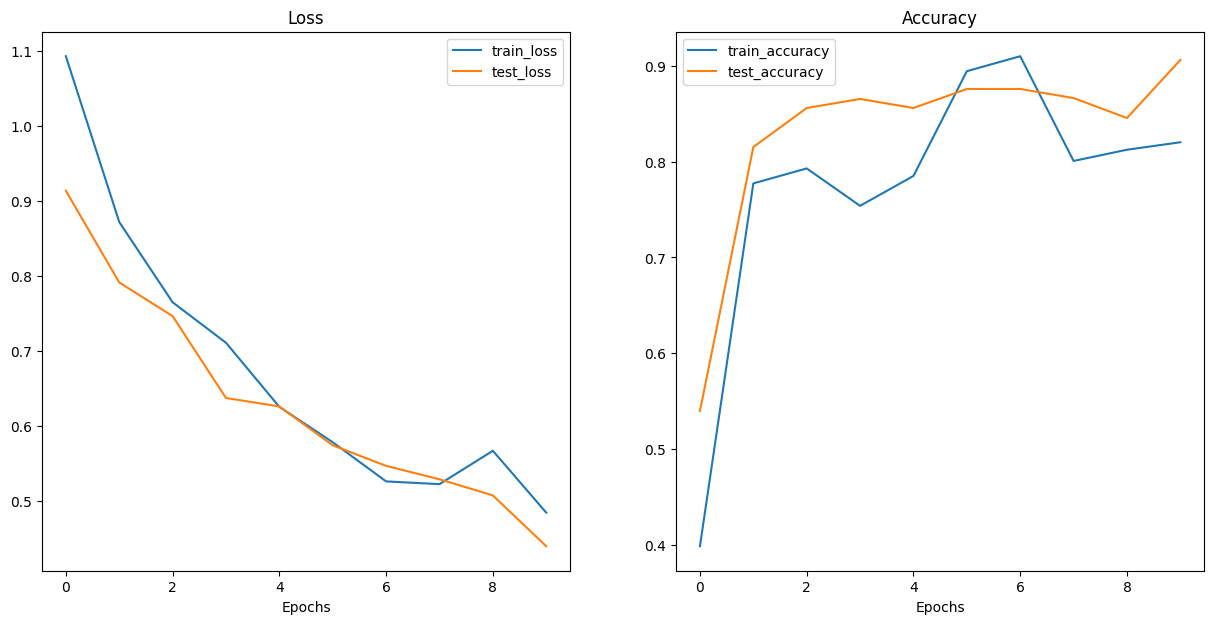

In [46]:
# Plot the loss curves
import requests


try:
  from helper_functions import plot_loss_curves
except:
  print(f"[INFO] Couldn't find helper_functions.py file to import plot_loss_curves function.\
          \nDid you change the name of the file?")
  with open("helper_functions.py", "wb") as f:
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    f.write(request.content)
  from helper_functions import plot_loss_curves


plot_loss_curves(results)